In [ ]:
from google.colab import drive
drive.mount('/content/drive')
userpath='/content/drive/MyDrive/CUAI'

Mounted at /content/drive


## 5.9 Regression 실습 - Bike Sharing Demand
### 데이터 클렌징 및 가공

* datetime: hourly date + timestamp
* season: 1=봄, 2=여름, 3=가을, 4=겨울
* holiday: 1=토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 나닌 날
* workingday: 1=토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일
* temp: 온도(섭씨)
* atemp: 체감온도(섭씨)
* humidity:상대습도
* windspeed:풍속
* casual: 사전에 등록되지 않는 사용자가 대여한 횟수
* registered: 사전에 등록된 사용자가 대여한 횟수
* count: 대여 횟수

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv(userpath+'/bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [ ]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


null data 없음. 대부분 칼럼이 int 또는 float형인데 datetime만 object형인데다가 년-월-일 시:분:초 형식이라 가공해주가공해주겠음.

In [ ]:
# 문자열을 datetime 타입으로 변경. 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [ ]:
drop_columns = ['datetime','casual','registered'] # datatime은 이제 없애도 되고 casual+registered=count라 없애주겠음. (분리할 경우 상관계수가 높아 예측 저해 우려 o)
bike_df.drop(drop_columns, axis=1,inplace=True)

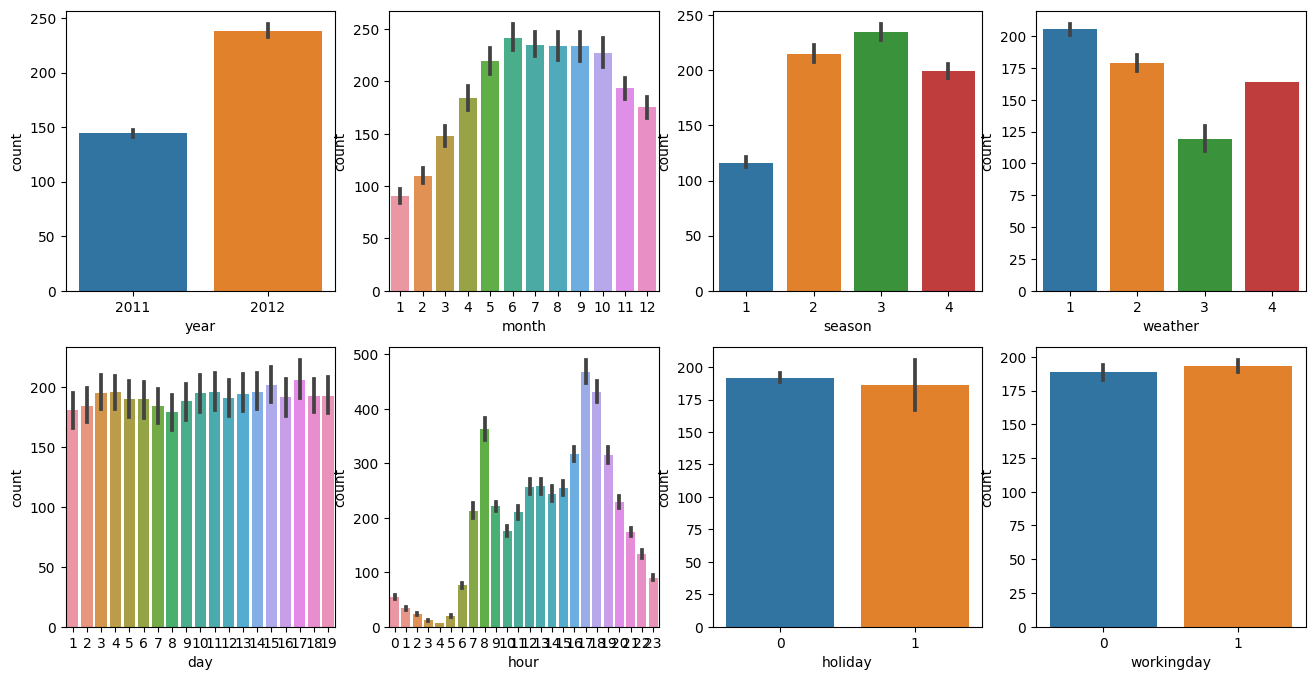

In [ ]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

캐글에서 요구한 성능 평가 방법은 RMSLE인데 sklearn에서 제공하지 않아 RMSLE를 수행하는 성능 평가 함수를 만들어보겠음. 기왕 만드는 거 MSE, RMSE까지 평가해주는 함수함수도 만들겠음.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

* rmsle()함수를 만들때: 데이터 값의 크기에 따라 오버플로, 언더플로 오류가 발생할 수 있다.
→ log()보단 log1p()를 이용해줌. 이렇게 변환된 값은 np의 expm1()함수로 쉽게 원래 스케일로 복원 가능.

### 로그 변환, 피처 인코딩, 모델 학습/예측/평가 

* 회귀 모델을 이용하여, 자전거 대여 횟수를 예측
* 적용하기 전, 데이터 세트에 대해서 결괏값이 정규 분포로 돼 있는지 확인해야하고 카테고리형 회귀 모델은 원-핫 인코딩으로 피처를 인코딩해야한다. 

In [ ]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [ ]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)


      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


예측 오류가 꽤 큼... 이럴 경우 Target 값의 분포가 왜곡된 형태를 이루진 않는지 확인해주는 게 좋음. (정규 분포 형태가 젤 good)

<Axes: >

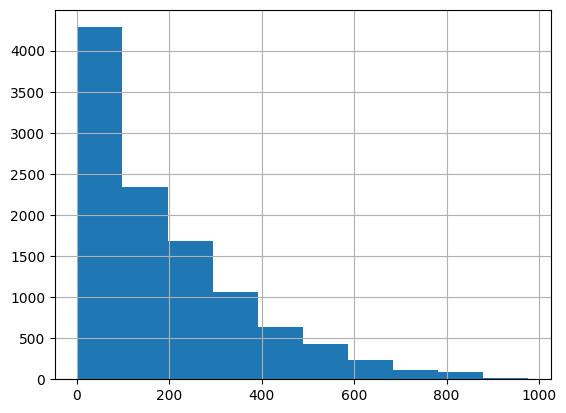

In [ ]:
y_target.hist()

역시나 정규분포가 아닌 0~200 사이에 왜곡돼 있음... np의 log1p()를 이용해 변환해주자. 

<Axes: >

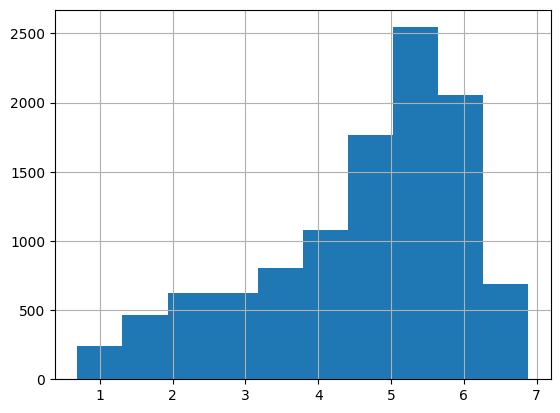

In [ ]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

정규분포 형태는 아니지만 변환 전보단 왜곡 정도가 많이 나아짐.

In [ ]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)


RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


* RMSLE 오류는 줄어들었지만, RMSE는 늘어났다. 개별 피처들의 인코딩 적용

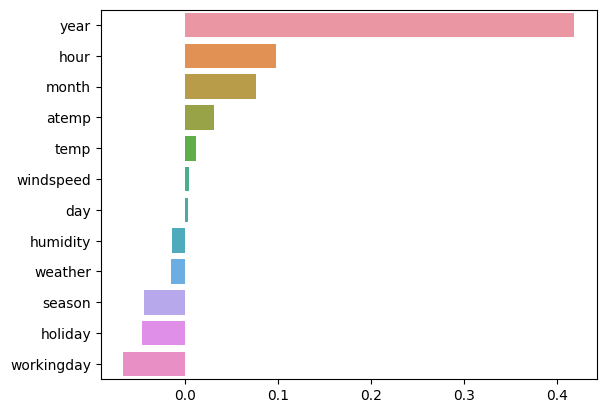

In [ ]:
# 각 feature의 회귀 계수 값을 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')

year, hour, month, season, holiday, workingday 들의 회귀 계수 영향도가 상대적으로 높음. 왜냐면 year는 2011, 2012 같은 형태고 month도 1, 2, ... 이런 형태임. 근데 이 feature는 개별 숫자들의 크기가 의미가 있는 게 아니잖음? year는 단순 연도, 즉 카테고리니까 2011<2012라고 인식해선 안 됨.

⇒ one-hot encoding 적용해 변환해야...

In [ ]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

* 사이킷런의 선형 회귀 모델인 LinearRegression, Ridge, Lasso 모두 학습해 예측 성능 확인

In [ ]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)


### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


예측 성능이 많이 향상됐음. 

<Axes: >

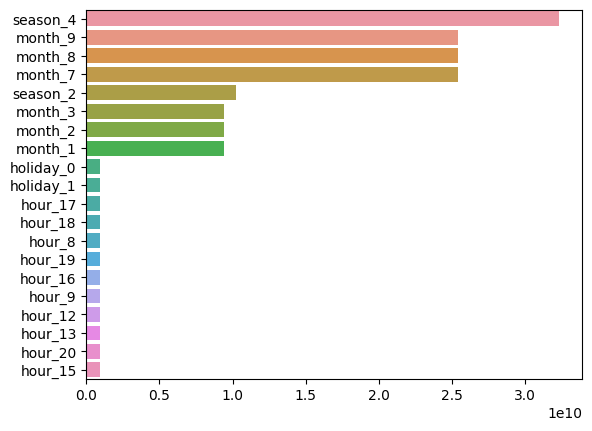

In [ ]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

아직도 year 관련 feature들의 회귀 계수 값이 가장 높지만, 다른 애들의 값도 상대적으로 커짐. 반드시 그런 건 아니지만 선형 회귀의 경우 중요 카테고리성 feature들은 one-hot encoding으로 변환해주는 게 성능에 중요한 영향을 미칠 수 있다.

* XGBoost는 DataFrame이 학습/테스트 데이터로 입력되는 경우 버전에 따라 오류가 발생하여, values 속성을 이용해 ndarray로 변환한다. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.172, MAE: 31.128
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.317, MAE: 32.733
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


* 앞의 선형 회귀 모델보다 회귀 예측 성능이 개선되었지만, 회귀 트리가 선형 회귀보다 더 나은 성능을 가지는 것이 아니다. 